[*********************100%%**********************]  1 of 1 completed
<ipython-input-1-a0fe3d4bdb33>:9: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-a0fe3d4bdb33>:13: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
<ipython-input-1-a0fe3d4bdb33>:15: RuntimeWarning: invalid value encountered in scalar divide
  theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)


                 Close   Returns  Cumulative Returns  Delta          Gamma  \
Date                                                                         
2023-12-22  193.600006 -0.005547            0.547933    1.0   1.769136e-20   
2023-12-26  193.050003 -0.002841            0.543536    1.0   6.554132e-44   
2023-12-27  193.149994  0.000518            0.544335    1.0   4.175562e-65   
2023-12-28  193.580002  0.002226            0.547773    1.0  1.581545e-130   
2023-12-29  192.529999 -0.005424            0.539378    1.0            NaN   

                     Vega     Theta  Delta Hedge Position  \
Date                                                        
2023-12-22   2.543356e-20 -7.492812                  -1.0   
2023-12-26   4.015255e-44 -7.496918                  -1.0   
2023-12-27   1.707149e-65 -7.497945                  -1.0   
2023-12-28  3.247428e-131 -7.498973                  -1.0   
2023-12-29   0.000000e+00       NaN                  -1.0   

            Gamma Hedge P

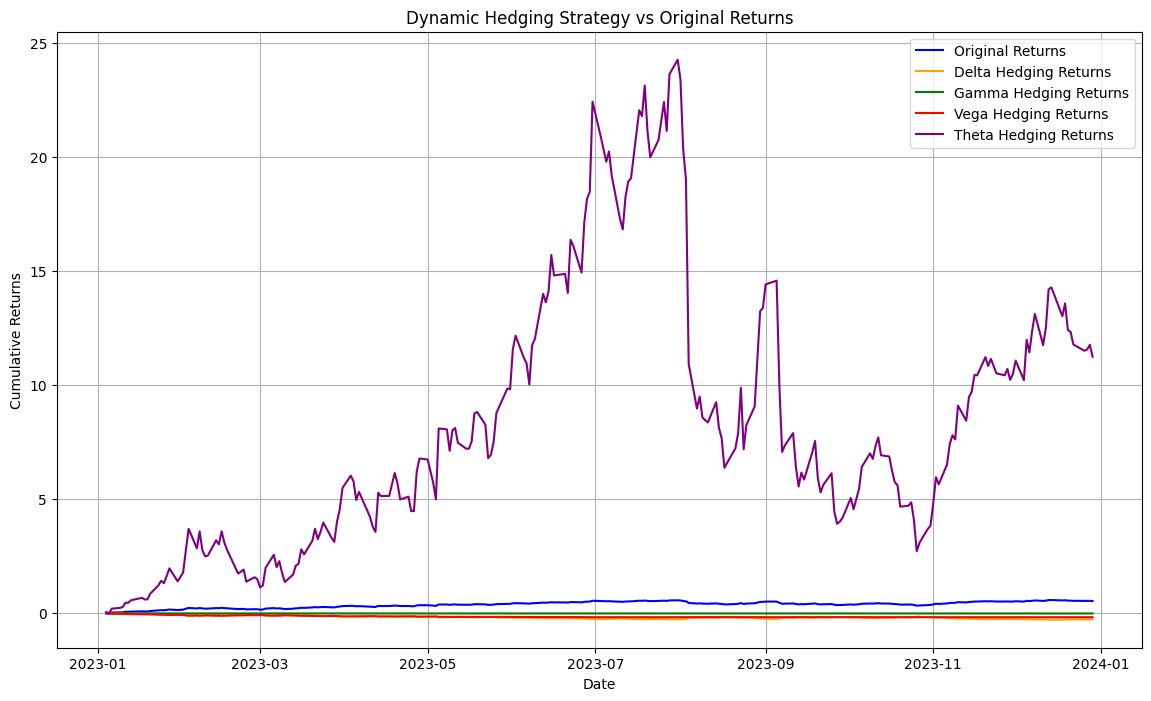

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes-Merton Greeks 계산 함수
def black_scholes_merton_greeks(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1) if option_type == "call" else norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # Vega per 1% change in volatility
    theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)

    return delta, gamma, vega, theta

# yfinance를 사용하여 데이터 다운로드
ticker = 'AAPL'
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
data['Returns'] = data['Close'].pct_change()

# 예제 파라미터
K = 150  # 행사가격
r = 0.05  # 무위험 이자율
sigma = 0.2  # 변동성
option_type = "call"

# 각 날짜에 대한 만기 시간(T) 계산
data['T'] = (data.index[-1] - data.index).days / 365.0

# Greeks 계산 및 Dynamic Hedging 전략 적용
greeks = data.apply(lambda row: black_scholes_merton_greeks(row['Close'], K, row['T'], r, sigma, option_type), axis=1)
data[['Delta', 'Gamma', 'Vega', 'Theta']] = pd.DataFrame(greeks.tolist(), index=data.index)

# Hedging 포지션 및 수익률 계산
data['Delta Hedge Position'] = -data['Delta']
data['Gamma Hedge Position'] = -data['Gamma']
data['Vega Hedge Position'] = -data['Vega']
data['Theta Hedge Position'] = -data['Theta']
data['Delta Hedge Returns'] = data['Delta Hedge Position'].shift(1) * data['Returns']
data['Gamma Hedge Returns'] = data['Gamma Hedge Position'].shift(1) * data['Returns']
data['Vega Hedge Returns'] = data['Vega Hedge Position'].shift(1) * data['Returns']
data['Theta Hedge Returns'] = data['Theta Hedge Position'].shift(1) * data['Returns']

# 누적 수익률 계산
data['Cumulative Returns'] = (1 + data['Returns']).cumprod() - 1
data['Cumulative Delta Hedge Returns'] = (1 + data['Delta Hedge Returns']).cumprod() - 1
data['Cumulative Gamma Hedge Returns'] = (1 + data['Gamma Hedge Returns']).cumprod() - 1
data['Cumulative Vega Hedge Returns'] = (1 + data['Vega Hedge Returns']).cumprod() - 1
data['Cumulative Theta Hedge Returns'] = (1 + data['Theta Hedge Returns']).cumprod() - 1

# 결과 출력
print(data[['Close', 'Returns', 'Cumulative Returns', 'Delta', 'Gamma', 'Vega', 'Theta', 'Delta Hedge Position', 'Gamma Hedge Position', 'Vega Hedge Position', 'Theta Hedge Position', 'Delta Hedge Returns', 'Gamma Hedge Returns', 'Vega Hedge Returns', 'Theta Hedge Returns', 'Cumulative Delta Hedge Returns', 'Cumulative Gamma Hedge Returns', 'Cumulative Vega Hedge Returns', 'Cumulative Theta Hedge Returns']].tail())

# 시각화
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Cumulative Returns'], label='Original Returns', color='blue')
plt.plot(data.index, data['Cumulative Delta Hedge Returns'], label='Delta Hedging Returns', color='orange')
plt.plot(data.index, data['Cumulative Gamma Hedge Returns'], label='Gamma Hedging Returns', color='green')
plt.plot(data.index, data['Cumulative Vega Hedge Returns'], label='Vega Hedging Returns', color='red')
plt.plot(data.index, data['Cumulative Theta Hedge Returns'], label='Theta Hedging Returns', color='purple')
plt.title('Dynamic Hedging Strategy vs Original Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
